In [1]:
import os 
import json
import time
import glob
import numpy as np
import pandas as pd
import datetime
import re
from collections import Counter

import matplotlib.pyplot as plt
from wordcloud import WordCloud

import spacy

nlp = spacy.load('en_core_web_sm')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)


In [2]:
# from rake_nltk import Rake

# r = Rake()

# '''
#     https://github.com/csurfer/rake-nltk
    
#     https://github.com/aneesha/RAKE
# '''


In [166]:
training_data = pd.read_csv('Stock market project - all training samples.csv')
training_data.shape

(693, 10)

In [167]:
training_data.head()

,dates,symbol,name,open price,1st price change,% change,time of 1st price change,published,news,label (p/n)
0,2020/10/02,HSBC,HSBC Holdings PLC,$19.51,$19.91,2.05%,2020-10-02T23:41:38,"Fri, 02 Oct 2020 18:00:11 GMT",HSBC Holdings plc (NYSE:HSBC) Currently 99.45%...,n
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Fri, 02 Oct 2020 17:19:17 GMT",Oman Cards and Payments Market Report- Growth ...,n
2,2020/10/02,LSCC,Lattice Semiconductor Corp,$29.75,$28.09,-5.58%,2020-10-03T00:10:57,-,-,NaN
3,2020/10/05,AGIO,Agios Pharmaceuticals Inc,$33.42,$36.38,8.86%,2020-10-06T00:11:38,"Mon, 05 Oct 2020 18:29:31 GMT","Agios Pharmaceuticals Inc (AGIO) Stock: Buy, H...",n
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Mon, 05 Oct 2020 17:18:00 GMT",Should be in your portfolio? Its Depends: Alle...,n


In [168]:
'''
    Complete the training dataset:
'''

dat = training_data.copy()

for i in range(1, dat.shape[0]):
    if pd.isnull(dat.iloc[i, 0]): # position 
        dat.iloc[i, :7] = dat.iloc[i-1, :7]



In [188]:
dat.dropna(how='all').shape, dat.shape

((693, 12), (693, 12))

In [171]:
'''
    news_source_list: list of website names 

'''

dat['news_source'] = ''
dat['news_wo_source'] = ''

news_source_list = []

for i in range(dat.shape[0]):
    tmp_news = dat.loc[i, 'news']
    tmp_news_list = tmp_news.split(' - ')
    if len(tmp_news_list) > 1:
        dat.loc[i, 'news_wo_source'] = ' - '.join(tmp_news_list[:-1])
        dat.loc[i, 'news_source'] = tmp_news_list[-1]
        if tmp_news_list[-1] not in news_source_list:
            news_source_list.append(tmp_news_list[-1])
    else:
        dat.loc[i, 'news_wo_source'] = tmp_news

len(news_source_list)

news_source_list[:10]

['Marketing Sentinel',
 'The Market Records',
 'InvestorsObserver',
 'BOV News',
 'Nasdaq',
 'Investing.com',
 'The InvestChronicle',
 'The Oracle Dispatch',
 'Simply Wall St',
 'Seeking Alpha']

In [172]:
dat.head()

,dates,symbol,name,open price,1st price change,% change,time of 1st price change,published,news,label (p/n),news_source,news_wo_source
0,2020/10/02,HSBC,HSBC Holdings PLC,$19.51,$19.91,2.05%,2020-10-02T23:41:38,"Fri, 02 Oct 2020 18:00:11 GMT",HSBC Holdings plc (NYSE:HSBC) Currently 99.45%...,n,Marketing Sentinel,HSBC Holdings plc (NYSE:HSBC) Currently 99.45%...
1,2020/10/02,HSBC,HSBC Holdings PLC,$19.51,$19.91,2.05%,2020-10-02T23:41:38,"Fri, 02 Oct 2020 17:19:17 GMT",Oman Cards and Payments Market Report- Growth ...,n,The Market Records,Oman Cards and Payments Market Report- Growth ...
2,2020/10/02,LSCC,Lattice Semiconductor Corp,$29.75,$28.09,-5.58%,2020-10-03T00:10:57,-,-,NaN,,-
3,2020/10/05,AGIO,Agios Pharmaceuticals Inc,$33.42,$36.38,8.86%,2020-10-06T00:11:38,"Mon, 05 Oct 2020 18:29:31 GMT","Agios Pharmaceuticals Inc (AGIO) Stock: Buy, H...",n,InvestorsObserver,"Agios Pharmaceuticals Inc (AGIO) Stock: Buy, H..."
4,2020/10/05,AGIO,Agios Pharmaceuticals Inc,$33.42,$36.38,8.86%,2020-10-06T00:11:38,"Mon, 05 Oct 2020 17:18:00 GMT",Should be in your portfolio? Its Depends: Alle...,n,BOV News,Should be in your portfolio? Its Depends: Alle...


### Split dataset into two subsets:
- dat_up: going up
- dat_down: going down

In [173]:
'''

'''
dat_up = dat[dat['% change'].map(lambda x: float(x.split('%')[0]) > 0)].reset_index(drop=True)
dat_down = dat[dat['% change'].map(lambda x: float(x.split('%')[0]) < 0)].reset_index(drop=True)

print(dat.shape, dat_up.shape, dat_down.shape)



(693, 12) (436, 12) (257, 12)


In [174]:
dat_up.groupby(['dates', 'symbol']).agg({'dates': len}).head()

# dat['name'].unique()

dates
dates      symbol       
2020/10/02 HSBC        2
2020/10/05 AGIO        3
           AQN         1
           LSCC        1
           MRVL        4

In [175]:
'''
    stocks_NameSymbolStr_dict
'''

stocks_NameSymbolStr_dict = {}

for s in list(sorted(dat['symbol'].unique())):
    tmp_NameStr = dat[dat['symbol'] == s]['name'].values[0]
    stocks_NameSymbolStr_dict[s] = ' '.join([s, tmp_NameStr])
    

In [176]:

def check_word_in_sent(word, sentence):
    # lowercase
    # words: list of word
    # sentence: string - stocks_NameSymbolStr_dict
    
    # all_words = re.findall(r'\w+', sentence)
    all_words = [t.text.lower() for t in nlp(sentence)]
    if word.lower() in all_words:
#         print('{}, Found!'.format(word))
        return True
    else:
#         print('{}, Not in sentence!'.format(word))
        return False


In [177]:
stocks_NameSymbolStr_dict['ZION'], \
check_word_in_sent('zion', stocks_NameSymbolStr_dict['ZION'])

('ZION Zions Bancorporation NA', True)

### Text data processing:

The necessary steps include (but aren’t limited to) the following:
1. Tokenizing sentences to break text down into sentences, words, or other units
2. Removing stop words like “if,” “but,” “or,” and so on


In [178]:
'''
    News data processing:
    - filter out:
        - company name and symbol
        - news sources: website name
        - stopwords
        - delimiters
        
'''

del_words = ['$', '|', 'inc.', 'inc', 'corp', 'corporation', 'company', 'co', 
             'stock', 'stocks', 'nyse', 'nasdaq', 'llc', 'ltd.', 'limited', 'ltd',
             'com', 'brands', 'market']

def get_keywords(data):
    
    d_copy = data.copy()
    d_copy['keywords_list'] = ''
    
    keywords_dict = {}
    keywords_list = []

    for i in range(data.shape[0]):
        s = data.loc[i, 'symbol']

        tmp_news = data.loc[i, 'news_wo_source']

        tmp_keywords = [(token.text.lower(), token.lemma_.lower(), token.pos_) for token in nlp(tmp_news) 
                         if not token.is_stop
                         if not token.is_punct
                         if not token.is_space
                         if not check_word_in_sent(token.text, stocks_NameSymbolStr_dict[s])
                         if token.text.lower() not in del_words
                         and any([c.isalpha() for c in token.text]) == True
                       ]
        
        d_copy.loc[i, 'keywords_list'] = tmp_keywords
        
        if s not in keywords_dict:
            keywords_dict[s] = []

        keywords_dict[s].extend(tmp_keywords)

        keywords_list.extend(tmp_keywords)
    
    return d_copy, keywords_dict, keywords_list


In [179]:
# data_up:
dat_up_copy, keywords_up_dict, keywords_up_list = get_keywords(dat_up)
print(len(dat_up['symbol'].unique()), len(keywords_up_dict.keys()), len(keywords_up_list))

72 72 2940


In [180]:
# data_down:
dat_down_copy, keywords_down_dict, keywords_down_list = get_keywords(dat_down)
print(len(dat_down['symbol'].unique()), len(keywords_down_dict.keys()), len(keywords_down_list))

43 43 1551


In [181]:
np.unique([k[2] for k in keywords_up_list])

array(['ADJ', 'ADP', 'ADV', 'CCONJ', 'NOUN', 'NUM', 'PROPN', 'PUNCT',
       'SCONJ', 'VERB', 'X'], dtype='<U5')

In [182]:
len(keywords_up_list), len(dict.fromkeys([k[1] for k in keywords_up_list])), \
len(keywords_down_list), len(dict.fromkeys([k[1] for k in keywords_down_list]))

(2940, 1395, 1551, 878)

In [183]:
keywords_up_list[:10]

[('currently', 'currently', 'ADV'),
 ('52-week', '52-week', 'NUM'),
 ('high', 'high', 'ADJ'),
 ('upside', 'upside', 'PROPN'),
 ('potential', 'potential', 'PROPN'),
 ('surprise', 'surprise', 'VERB'),
 ('oman', 'oman', 'PROPN'),
 ('cards', 'cards', 'PROPN'),
 ('payments', 'payments', 'PROPN'),
 ('report-', 'report-', 'PROPN')]

In [184]:
Counter([k[1] for k in keywords_up_list if k[2] == 'VERB']).most_common(10)

[('buy', 31),
 ('sell', 14),
 ('rise', 13),
 ('announce', 12),
 ('beat', 11),
 ('acquire', 10),
 ('get', 10),
 ('investigate', 8),
 ('lead', 7),
 ('say', 7)]

In [185]:
Counter([k[1] for k in keywords_down_list if k[2] == 'VERB']).most_common(10)

[('lead', 12),
 ('fall', 7),
 ('say', 6),
 ('buy', 6),
 ('post', 5),
 ('raise', 5),
 ('watch', 4),
 ('score', 4),
 ('hit', 4),
 ('drop', 4)]

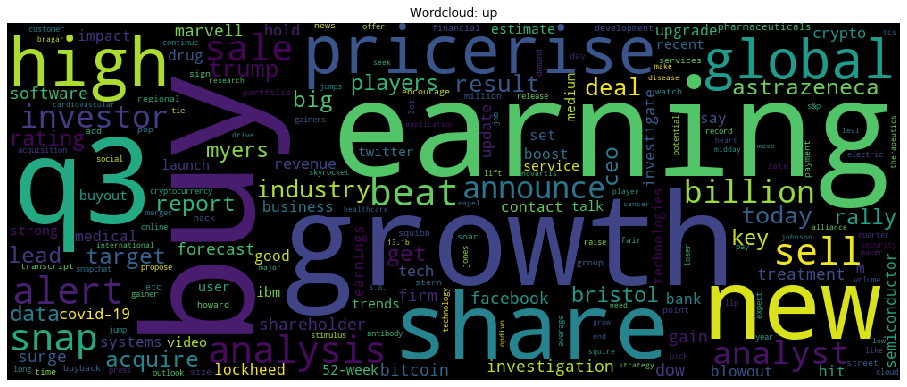

In [186]:
wordcloud_up = WordCloud(background_color='black', height=400,
                        width=1000).generate_from_frequencies(
                        Counter([k[1] for k in keywords_up_list]))

# Plot the wordcloud
plt.figure(figsize=(16,8))
plt.imshow(wordcloud_up)
plt.axis('off')
plt.title('Wordcloud: up')
# plt.savefig('wordcloud_up.png')
plt.show()
plt.close()

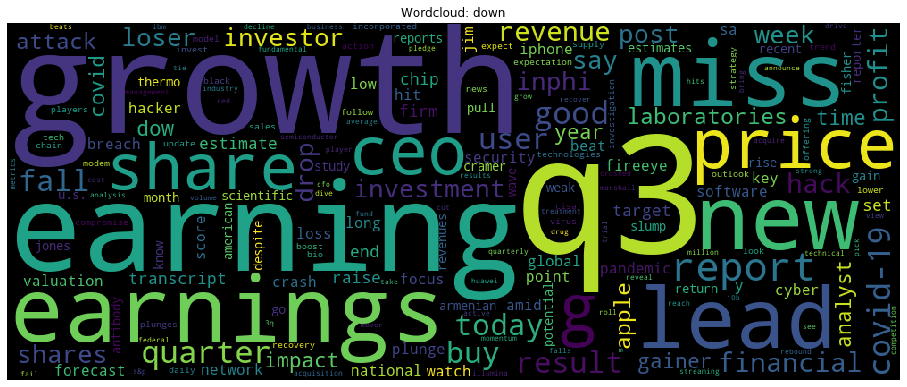

In [187]:
wordcloud_down = WordCloud(background_color='black', height=400,
                        width=1000).generate_from_frequencies(
                        Counter([k[1] for k in keywords_down_list]))

# Plot the wordcloud
plt.figure(figsize=(16,8))
plt.imshow(wordcloud_down)
plt.axis('off')
plt.title('Wordcloud: down')
# plt.savefig('wordcloud_down.png')
plt.show()
plt.close()

#### Process keywords list:
- one-hot encoding

In [300]:
# up
tmp_data = dat_up_copy[['dates', 'symbol', 'news', 'label (p/n)', 'keywords_list']].copy()
print(tmp_data.shape)
tmp_data = tmp_data.dropna().reset_index(drop=True)
print(tmp_data.shape)

all_keywords_list = sorted(list(dict.fromkeys([k[1] for k in keywords_up_list]).keys()))[12:]
print(len(all_keywords_list))
keywords_most_common_100 = sorted([w[0] for w in Counter([k[1] for k in keywords_up_list]).most_common(100)])

# all nouns and verbs
all_keywords_noun_verb_list = sorted(list(dict.fromkeys([k[1] for k in keywords_up_list 
                                                         if k[2] in ['VERB', 'NOUN']]).keys()))[3:]
keywords_most_common_noun_verb_100 = sorted([w[0] for w in Counter([k[1] for k in keywords_up_list
                                                                   if k[2] in ['VERB', 'NOUN']]).most_common(100)])


tmp_data.head()

(436, 5)
(342, 5)
1383


,dates,symbol,news,label (p/n),keywords_list
0,2020/10/02,HSBC,HSBC Holdings plc (NYSE:HSBC) Currently 99.45%...,n,"[(currently, currently, ADV), (52-week, 52-wee..."
1,2020/10/02,HSBC,Oman Cards and Payments Market Report- Growth ...,n,"[(oman, oman, PROPN), (cards, cards, PROPN), (..."
2,2020/10/05,AGIO,"Agios Pharmaceuticals Inc (AGIO) Stock: Buy, H...",n,"[(buy, buy, VERB), (hold, hold, VERB), (sell, ..."
3,2020/10/05,AGIO,Should be in your portfolio? Its Depends: Alle...,n,"[(portfolio, portfolio, NOUN), (depends, depen..."
4,2020/10/05,AGIO,All You Need to Know About Agios Pharmaceutica...,n,"[(need, need, VERB), (know, know, VERB), (rati..."


In [301]:
tmp_data['all_keywords_encoded'] = ''
tmp_data['keywords_100_encoded'] = ''

X_all = []
X_100 = []
X_all_noun_verb = []
X_100_noun_verb = []

for i in range(tmp_data.shape[0]):
    tmp_k = [k[1] for k in tmp_data.loc[i, 'keywords_list']]

    tmp_all_keywords_index = [all_keywords_list.index(k) for k in tmp_k if k in all_keywords_list]
    tmp_all_keywords_encoded = np.zeros(len(all_keywords_list))
    for c in tmp_all_keywords_index:
        tmp_all_keywords_encoded[c] = 1
    
    tmp_keywords_100_encoded = np.zeros(100)
    tmp_keywords_100_index = [keywords_most_common_100.index(k) for k in tmp_k if k in keywords_most_common_100]
    for k in tmp_keywords_100_index:
        tmp_keywords_100_encoded[k] = 1
       
    X_all.append(tmp_all_keywords_encoded)
    X_100.append(tmp_keywords_100_encoded)
    tmp_data.loc[i, 'all_keywords_encoded'] = tmp_all_keywords_encoded
    tmp_data.loc[i, 'keywords_100_encoded'] = tmp_keywords_100_encoded
    
    # noun and verb
    tmp_all_keywords_nv_index = [all_keywords_noun_verb_list.index(k) for k in tmp_k 
                                if k in all_keywords_noun_verb_list]
    tmp_all_keywords_nv_encoded = np.zeros(len(all_keywords_noun_verb_list))
    for c in tmp_all_keywords_nv_index:
        tmp_all_keywords_nv_encoded[c] = 1
    
    tmp_keywords_nv_100_index = [keywords_most_common_noun_verb_100.index(k) for k in tmp_k
                                if k in keywords_most_common_noun_verb_100]
    tmp_keywords_nv_100_encoded = np.zeros(100)
    for c in tmp_keywords_nv_100_index:
        tmp_keywords_nv_100_encoded[c] = 1
        
    X_all_noun_verb.append(tmp_all_keywords_nv_encoded)
    X_100_noun_verb.append(tmp_keywords_nv_100_encoded)

In [302]:
tmp_data.head()

,dates,symbol,news,label (p/n),keywords_list,all_keywords_encoded,keywords_100_encoded
0,2020/10/02,HSBC,HSBC Holdings plc (NYSE:HSBC) Currently 99.45%...,n,"[(currently, currently, ADV), (52-week, 52-wee...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,2020/10/02,HSBC,Oman Cards and Payments Market Report- Growth ...,n,"[(oman, oman, PROPN), (cards, cards, PROPN), (...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
2,2020/10/05,AGIO,"Agios Pharmaceuticals Inc (AGIO) Stock: Buy, H...",n,"[(buy, buy, VERB), (hold, hold, VERB), (sell, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,2020/10/05,AGIO,Should be in your portfolio? Its Depends: Alle...,n,"[(portfolio, portfolio, NOUN), (depends, depen...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,2020/10/05,AGIO,All You Need to Know About Agios Pharmaceutica...,n,"[(need, need, VERB), (know, know, VERB), (rati...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [310]:
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

from sklearn.model_selection import train_test_split

In [322]:
'''
    data preprocessing
'''
X_all = pd.DataFrame(X_all, columns=all_keywords_list)

X_100 = pd.DataFrame(X_100, columns=keywords_most_common_100)

X_all_noun_verb = pd.DataFrame(X_all_noun_verb, columns=all_keywords_noun_verb_list)

X_100_noun_verb = pd.DataFrame(X_100_noun_verb, columns=keywords_most_common_noun_verb_100)

y = tmp_data['label (p/n)']


### Split data into training and testing sets

X_train_all, X_test_all, y_train, y_test = train_test_split(X_all, y, test_size = 0.25, random_state = 123)

print('Training X shape:', X_train_all.shape)
print('Training y shape:', y_train_all.shape)
print('Testing X shape:', X_test_all.shape)
print('Testing y shape:', y_test_all.shape)


X_train_100 = X_100.loc[X_train_all.index]
X_test_100 = X_100.loc[X_test_all.index]

Training X shape: (256, 1383)
Training y shape: (256,)
Testing X shape: (86, 1383)
Testing y shape: (86,)


In [324]:
X_train_all.head()

,52-week,abbott,abbvie,able,accenture,accept,account,aces,acquire,acquisition,acronis,action,active,activity,ad,adapted,add,adjust,adjusts,advantage,advertising,aerial,affirms,afternoon,ag,ageagle,agilent,agree,agreement,ahead,aid,aim,air,airlines,akka,al,alere,alert,alexion,alibaba,aligner,allena,allergan,alliance,alna,alorica,altair,alten,altran,amazon,amc,america,american,amex,amgen,amid,amplify,analysis,analyst,analysts,analytics,ancn,announce,announcement,announces,annoying,antibody,apartment,aphria,appdynamics,appear,appian,apple,application,applications,applied,appnomic,apptio,arbitrate,arby,aricent,armenian,arnold,arvinas,asaf,assessments,associate,astrazeneca,at&t,ataxia,atento,atheros,attack,attention,authanvil,average,avoid,bad,baidu,bancorp,bandwagon,bank,banks,baosteel,barbour,barr,barracuda,base,based,baskin,batten,bbb-,bch,bd,beat,behalf,behavior,benefit,bertrandt,best,big,billion,bio,biogen,biolase,biomarin,bioscience,biosciences,biotech,biotechnology,bitcoin,bitlicense,bitrix,bizwomen,block,blog,blow,blowout,blue,bms,bmy,bnp,board,bob,bofa,bolster,bolt,bombard,bonanza,bond,boom,boost,boots,bother,bought,bounces,boycott,bragar,brand,breach,breaches,break,breakout,briefing,bring,brinker,bristol,broadband,broadcom,brokerage,bronco,btc,build,bulkers,buoy,business,button,buy,buyback,buyout,buys,buzz,cable,cagr,california,campaign,cancer,canon,cantor,cap,capgemini,capital,cardiovascular,cards,caroffer,cash,catalyst,ccar,cell,center,centers,centreon,centrify,ceo,certain,chain,channel,chase,checkmk,cheer,chicago,chile,china,chip,chipset,chipsets,choice,churnzero,circumstance,cisco,citrix,city,claim,claims,class,clean,clear,clearance,cleveland,cliffs,climb,clinical,close,clothing,cloud,cloudentr,co.,cocktail,code,coffee,cognizant,coleman,collaborative,colorectal,come,comms,communication,communications,community,companies,...,single,sink,siriusxm,situation,size,skyrocket,slack,slime,small,smart,smile,smith,snag,snap,snapchat,snapshot,snow,snowflake,snyk,soar,social,software,sohar,solutions,songwriters,sophos,source,spat,special,spectrum,spend,spike,spreadtrum,springer,spur,squibb,squire,ssys,stability,stable,stackrox,stage,stake,stalls,stanley,state,steel,stern,stick,sticker,stimulus,story,stratasys,strategy,strauss,stream,street,strengthens,strong,strongly,stumble,subs,subscriber,subscribers,succeed,success,successful,sue,suisse,suit,suite,summit,sumo,sunny,suplari,supply,support,suresale,surge,surgery,surges,surpass,surprise,sweet,swing,switch,swot,symantec,synchrony,synopsis,sysdig,system,systems,tab,taiwan,take,takeout,takeover,talk,talks,tank,target,targeted,targets,tax,tcs,team,tech,technological,technologies,technology,tempt,term,termination,tesla,test,testify,testing,tether,therapeutics,therapy,thermo,thing,think,thursday,tie,tigr,tilray,timbercove,time,timely,tock,today,tom,tool,tooling,toshiba,touch,tough,toyota,track,trade,trader,trades,trading,transcript,transit,treasury,treat,treatment,trend,trends,trial,trinity,trouble,trump,trust,tsm,tumbles,turbonomic,tv,tweet,twitter,twu,type,types,uaa,ultimate,unappreciate,unclassified,undefined,underrepresented,unexpected,united,unsure,upbeat,upcoming,update,updates,updating,upgrade,upgrades,upside,upsized,usa,usdc,use,user,users,v8,vaccine,validation,valuable,valuation,value,van,vehicle,vendor,vendors,veoneer,veru,video,view,views,virtual,virtualization,virus,vitaflo,vmware,vne,volume,walgreens,wall,walt,want,warn,watch,weak,web,wednesday,week,weekly,weigh,weight,well,wells,wfc,white,wi,wide,win,winner,witness,work,workers,worldwide,worth,wrap,write,xi,xtant,y,year,yext,yield,york,zabbix,zacks,zionl,zoom
248,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [323]:
X_train_100.head()

,52-week,acquire,alert,analysis,analyst,announce,astrazeneca,bank,beat,big,billion,bitcoin,blowout,boost,bristol,business,buy,buyout,ceo,contact,covid-19,crypto,data,deal,development,dow,drug,earning,earnings,encourage,estimate,facebook,fair,financial,firm,forecast,gain,get,global,good,growth,high,hit,hold,ibm,impact,industry,investigate,investigation,investor,key,launch,lead,lockheed,m,marvell,medical,medium,myers,new,news,pharmaceuticals,players,portfolio,price,q3,rally,rating,recent,report,result,revenue,rise,sale,say,sell,semiconductor,service,set,share,shareholder,snap,software,squibb,strong,surge,systems,talk,target,tech,technologies,today,treatment,trends,trump,twitter,update,upgrade,user,video
248,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
142,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [316]:
y_train.head()

248    y
74     n
53     y
22     y
142    y
Name: label (p/n), dtype: object

#### Logistic Regression

In [325]:
LR_all = LogisticRegression(random_state=123).fit(X_train_all, y_train)

LR_100 = LogisticRegression(random_state=123).fit(X_train_100, y_train)


In [274]:
coef_all = pd.DataFrame(LR_all.coef_).T
coef_all.index = all_keywords_list

coef_100 = pd.DataFrame(LR_100.coef_).T
coef_100.index = keywords_most_common_100

In [275]:
coef_all.sort_values(by = 0)[:20]

,0
pick,-0.932114
value,-0.913602
target,-0.910532
price,-0.796937
fall,-0.770258
condition,-0.756741
rally,-0.717669
gainers,-0.705397
analysis,-0.696886
s&p,-0.690600


In [257]:
coef_all.sort_values(by = 0, ascending=False)[:20]

,0
q3,1.055570
earning,0.934383
astrazeneca,0.759165
billion,0.745544
acquire,0.731853
new,0.683795
announce,0.665266
trump,0.648351
semiconductor,0.647852
marvell,0.642607


In [258]:
coef_100.sort_values(by=0)[:20]

,0
analysis,-1.089443
target,-0.953134
rally,-0.820817
recent,-0.792567
high,-0.753394
industry,-0.721314
price,-0.718465
portfolio,-0.684299
hold,-0.638147
encourage,-0.560248


In [259]:
coef_100.sort_values(by=0, ascending=False)[:20]

,0
q3,1.183466
earning,1.092796
crypto,1.025336
development,0.965689
astrazeneca,0.953943
new,0.939437
systems,0.928103
set,0.914186
semiconductor,0.900379
billion,0.889285


In [307]:
logit_model = sm.Logit([int(w == 'y') for w in y.values],
                           X_100_noun_verb)
result = logit_model.fit(method = 'bfgs')
result.summary()

         Current function value: 0.328158
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/Users/lin/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/lin/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  342
Model:                          Logit   Df Residuals:                      246
Method:                           MLE   Df Model:                           95
Date:                Mon, 28 Dec 2020   Pseudo R-squ.:                  0.3928
Time:                        22:21:31   Log-Likelihood:                -112.23
converged:                      False   LL-Null:                       -184.84
Covariance Type:            nonrobust   LLR p-value:                 0.0007017
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
acquire           6.9914        nan        nan        nan         nan         nan
ad                2.6655        nan        nan        nan         nan         nan
add               1.8773        nan        nan        nan         nan         nan
agree            -1.2434        nan        nan        nan         nan         nan
alert             0.2865        nan        nan        nan         nan         nan
analyst           0.6506        nan        nan        nan         nan         nan
announce          5.9787        nan        nan        nan         nan         nan
base              2.7261        nan        nan        nan         nan         nan
beat              4.3602        nan        nan        nan         nan         nan
boost             0.6978        nan        nan        nan         nan         nan
business          3.7329        nan        nan        nan         nan         nan
buy               0.9157        nan        nan        nan         nan         nan
buyback           3.3555        nan        nan        nan         nan         nan
ceo               4.5770        nan        nan        nan         nan         nan
consider          1.4077        nan        nan        nan         nan         nan
contact          -1.2521        nan        nan        nan         nan         nan
continue          0.0238        nan        nan        nan         nan         nan
customer          2.4578        nan        nan        nan         nan         nan
day               0.2377        nan        nan        nan         nan         nan
deal              2.2301        nan        nan        nan         nan         nan
demand           -1.0533        nan        nan        nan         nan         nan
drive            -0.0734        nan        nan        nan         nan         nan
drug              4.3663        nan        nan        nan         nan         nan
earning           1.4856        nan        nan        nan         nan         nan
encourage        -3.1557        nan        nan        nan         nan         nan
end               2.2862        nan        nan        nan         nan         nan
estimate          2.3099        nan        nan        nan         nan         nan
expect            0.9107        nan        nan        nan         nan         nan
firm             -0.4481        nan        nan        nan         nan         nan
gain             -0.2571        nan        nan        nan         nan         nan
gainer           -2.4400        nan        nan        nan         nan         nan
get               3.8107        nan        nan        nan         nan         nan
grow             -1.3001        nan        nan        nan         nan         nan
growth            0.3277        nan        nan        nan         nan         nan
high             -1.8534        nan        nan        nan         nan         nan
hit               0.0098        nan        nan        nan         nan         nan
hold             -1.9375        nan        

### Random Forest

In [308]:
from sklearn.ensemble import RandomForestClassifier

In [343]:
RF_all = RandomForestClassifier(n_estimators=1000, random_state=123).fit(X_train_all, y_train)
RF_100 = RandomForestClassifier(n_estimators=1000, random_state=123).fit(X_train_100, y_train)

RF_pred_all = RF_all.predict(X_test_all)
RF_pred_100 = RF_100.predict(X_test_100)



In [344]:
# Calculate the absolute errors
RF_errors_all = [1-int(r) for r in list(RF_pred_all == y_test_all)]
RF_errors_100 = [1-int(r) for r in list(RF_pred_all == y_test_all)]

print('MAE_all:', round(np.mean(RF_errors_all), 2), 'degrees.')
print('MAE_100', round(np.mean(RF_errors_100), 2), 'degrees.')

MAE_all: 0.21 degrees.
MAE_100 0.21 degrees.


In [357]:
RF_importances_all = RF_all.feature_importances_
RF_importances_100 = RF_100.feature_importances_

feature_imp_all = sorted([(f, round(imp, 4)) for f, imp in zip(all_keywords_list, RF_importances_all)], 
                         key = lambda x: x[1], reverse=True)
feature_imp_100 = sorted([(f, round(imp, 4)) for f, imp in zip(keywords_most_common_100, RF_importances_100)], 
                         key = lambda x: x[1], reverse=True)

In [359]:
feature_imp_100[:10]

[('analysis', 0.0423),
 ('recent', 0.0285),
 ('portfolio', 0.0276),
 ('upgrade', 0.0276),
 ('earning', 0.0261),
 ('good', 0.0246),
 ('analyst', 0.0212),
 ('medical', 0.0212),
 ('industry', 0.0209),
 ('price', 0.0191)]

([<matplotlib.axis.XTick at 0x1a33bd6150>,
 <a list of 20 Text xticklabel objects>)

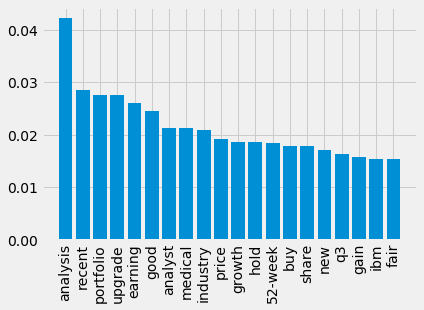

In [365]:
n_f = 20

plt.style.use('fivethirtyeight')

plt.bar(list(range(n_f)), [x[1] for x in feature_imp_100[:n_f]], orientation = 'vertical')

plt.xticks(list(range(n_f)), [x[0] for x in feature_imp_100[:n_f]], rotation = 'vertical')
